### Libraries 

In [401]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
import geopy.distance
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [353]:
df_orders = pd.read_csv("orders.csv")
df_orders

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822
...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,-33.417677,-70.508377,2019-10-19 01:00:00+00:00,False,9cf7b3c6a05745b24eb07e0945ff1718,c4ca4238a0b923820dcc509a6f75849b,116.631287
9996,0b91a6dc570736f490ade9b129bbd46f,-33.432885,-70.646795,2019-10-19 19:00:00+00:00,False,6fd0c09e971aff77c73afb87863da1c6,3871bd64012152bfb53fdf04b401193f,94.094497
9997,229d80f473668d9b25d60ea4d05687dd,-33.424562,-70.582943,2019-10-19 01:00:00+00:00,False,3ed51e3e0e8c9ca2fec3f84766cabe96,1f0e3dad99908345f7439f8ffabdffc4,53.784000
9998,96e2a7a69e52eaa5ce563b1164f72c8d,-33.413806,-70.598500,2019-10-19 18:00:00+00:00,False,cea50f5aa525cfe6d2f445fec7c8ef31,1f0e3dad99908345f7439f8ffabdffc4,52.806311


### Step 1) Shoppers data grouping
#### In this step, join the data of shopper in order data 

In [354]:
df_shoppers = pd.read_csv("shoppers.csv")
df_shoppers

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88
...,...,...,...,...,...,...
2859,da24da1311f7913f6d2d29d8238b439c,6c90661e6d2c7579f5ce337c3391dbb9,0.8951,1.53,0.88,4.80
2860,cf95eda5ffc1d4b9586de2ca08ab40f8,50e13ee63f086c2fe84229348bc91b5b,0.8695,3.00,0.56,5.00
2861,e8482e3ad8bc820ec756566a472b84b1,6c90661e6d2c7579f5ce337c3391dbb9,0.9152,1.47,0.88,4.96
2862,a55a3765a02530a97eb9af7aee327486,6c90661e6d2c7579f5ce337c3391dbb9,0.8695,1.20,0.96,4.80


In [355]:
#exploring data
df_shoppers.describe()

,found_rate,picking_speed,accepted_rate,rating
count,2763.000000,2864.000000,2837.000000,2780.000000
mean,0.861082,1.762392,0.908276,4.848428
std,0.031038,0.665962,0.107911,0.133011
min,0.737300,0.650000,0.240000,3.880000
25%,0.842900,1.290000,0.880000,4.800000
50%,0.863900,1.580000,0.944444,4.880000
75%,0.881950,2.120000,1.000000,4.960000
max,0.971000,7.040000,1.000000,5.000000


In [356]:
#explore missing data
df_shoppers.isnull().sum()/len(df_shoppers)

shopper_id       0.000000
seniority        0.000000
found_rate       0.035265
picking_speed    0.000000
accepted_rate    0.009427
rating           0.029330
dtype: float64

In [357]:
#Using k-neighbors for null imputation
knn = KNNImputer(n_neighbors=5)
df_shoppers[['found_rate','picking_speed','accepted_rate','rating']] = knn.fit_transform(df_shoppers[['found_rate','picking_speed','accepted_rate','rating']])
df_shoppers

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.000000,4.870
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.920000,4.920
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.000000,4.880
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,0.8534,2.41,0.781773,4.912
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.920000,4.880
...,...,...,...,...,...,...
2859,da24da1311f7913f6d2d29d8238b439c,6c90661e6d2c7579f5ce337c3391dbb9,0.8951,1.53,0.880000,4.800
2860,cf95eda5ffc1d4b9586de2ca08ab40f8,50e13ee63f086c2fe84229348bc91b5b,0.8695,3.00,0.560000,5.000
2861,e8482e3ad8bc820ec756566a472b84b1,6c90661e6d2c7579f5ce337c3391dbb9,0.9152,1.47,0.880000,4.960
2862,a55a3765a02530a97eb9af7aee327486,6c90661e6d2c7579f5ce337c3391dbb9,0.8695,1.20,0.960000,4.800


In [358]:
#change seniority to numerical values
df_shoppers.seniority.unique()

array(['41dc7c9e385c4d2b6c1f7836973951bf',
       '6c90661e6d2c7579f5ce337c3391dbb9',
       '50e13ee63f086c2fe84229348bc91b5b',
       'bb29b8d0d196b5db5a5350e5e3ae2b1f'], dtype=object)

In [359]:
df_shoppers = pd.get_dummies(df_shoppers, columns = ["seniority"], drop_first = False)
df_shoppers.columns = ["shopper_id","found_rate","picking_speed","accepted_rate","rating","sen1","sen2","sen3","sen4"]
df_shoppers

,shopper_id,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,0.8606,1.94,1.000000,4.870,1,0,0,0
1,e1c679ac73a69c01981fdd3c5ab8beda,0.8446,1.23,0.920000,4.920,0,0,1,0
2,09d369c66ca86ebeffacb133410c5ee1,0.8559,1.56,1.000000,4.880,0,0,1,0
3,db39866e62b95bb04ebb1e470f2d1347,0.8534,2.41,0.781773,4.912,0,1,0,0
4,8efbc238660053b19f00ca431144fdae,0.8770,1.31,0.920000,4.880,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2859,da24da1311f7913f6d2d29d8238b439c,0.8951,1.53,0.880000,4.800,0,0,1,0
2860,cf95eda5ffc1d4b9586de2ca08ab40f8,0.8695,3.00,0.560000,5.000,0,1,0,0
2861,e8482e3ad8bc820ec756566a472b84b1,0.9152,1.47,0.880000,4.960,0,0,1,0
2862,a55a3765a02530a97eb9af7aee327486,0.8695,1.20,0.960000,4.800,0,0,1,0


#### Done!, now the next step, join shopper label to orders data

In [360]:
df_orders = pd.merge(df_orders,df_shoppers,on='shopper_id',how='left').drop(['shopper_id'], axis=1)
df_orders

,order_id,lat,lng,promised_time,on_demand,store_branch_id,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,65ded5353c5ee48d0b7d48c591b8f430,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,f1748d6b0fd9d439f71450117eba2725,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,-33.417677,-70.508377,2019-10-19 01:00:00+00:00,False,c4ca4238a0b923820dcc509a6f75849b,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0
9996,0b91a6dc570736f490ade9b129bbd46f,-33.432885,-70.646795,2019-10-19 19:00:00+00:00,False,3871bd64012152bfb53fdf04b401193f,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0
9997,229d80f473668d9b25d60ea4d05687dd,-33.424562,-70.582943,2019-10-19 01:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0
9998,96e2a7a69e52eaa5ce563b1164f72c8d,-33.413806,-70.598500,2019-10-19 18:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0


### Step 2) Distance from store to delivery location
#### In this step we calculate the distance using geoy.distance library

In [361]:
df_store = pd.read_csv("storebranch.csv")
df_store 

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229
...,...,...,...,...
471,045117b0e0a11a242b9765e79cbf113f,a87ff679a2f3e71d9181a67b7542122c,-33.036111,-71.524149
472,2cfa3753d6a524711acb5fce38eeca1a,3f67fd97162d20e6fe27748b5b372509,-33.406081,-70.598128
473,7486cef2522ee03547cfb970a404a874,8f468c873a32bb0619eaeb2050ba45d1,-33.397498,-70.584666
474,c06d06da9666a219db15cf575aff2824,9a1158154dfa42caddbd0694a4e9bdc8,-33.390604,-70.547206


In [362]:
#join the lat-lng from store data to orders data, firts changue the names of those columns
df_store.columns = ['store_branch_id','store_id','lat_store','lng_store']
df_orders = pd.merge(df_orders,df_store[['store_branch_id','lat_store','lng_store']],on='store_branch_id',how='left')
df_orders

,order_id,lat,lng,promised_time,on_demand,store_branch_id,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,lat_store,lng_store
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,65ded5353c5ee48d0b7d48c591b8f430,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,-33.485280,-70.579250
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,-33.441246,-70.535450
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0,-33.008213,-71.545615
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,f1748d6b0fd9d439f71450117eba2725,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,-33.355258,-70.537787
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,-33.386547,-70.568075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,-33.417677,-70.508377,2019-10-19 01:00:00+00:00,False,c4ca4238a0b923820dcc509a6f75849b,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,-33.402024,-70.516727
9996,0b91a6dc570736f490ade9b129bbd46f,-33.432885,-70.646795,2019-10-19 19:00:00+00:00,False,3871bd64012152bfb53fdf04b401193f,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,-33.451695,-70.692160
9997,229d80f473668d9b25d60ea4d05687dd,-33.424562,-70.582943,2019-10-19 01:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,-33.386547,-70.568075
9998,96e2a7a69e52eaa5ce563b1164f72c8d,-33.413806,-70.598500,2019-10-19 18:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,-33.386547,-70.568075


In [363]:
#and calculate the distance in new column
df_orders['distance'] = df_orders.apply(lambda x: geopy.distance.geodesic((x[1],x[2]),(x[15],x[16])).km, axis=1)
df_orders

,order_id,lat,lng,promised_time,on_demand,store_branch_id,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,lat_store,lng_store,distance
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,65ded5353c5ee48d0b7d48c591b8f430,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,-33.485280,-70.579250,1.818407
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,-33.441246,-70.535450,1.938544
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0,-33.008213,-71.545615,2.351240
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,f1748d6b0fd9d439f71450117eba2725,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,-33.355258,-70.537787,3.815982
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,-33.386547,-70.568075,1.889404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,-33.417677,-70.508377,2019-10-19 01:00:00+00:00,False,c4ca4238a0b923820dcc509a6f75849b,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,-33.402024,-70.516727,1.902000
9996,0b91a6dc570736f490ade9b129bbd46f,-33.432885,-70.646795,2019-10-19 19:00:00+00:00,False,3871bd64012152bfb53fdf04b401193f,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,-33.451695,-70.692160,4.705961
9997,229d80f473668d9b25d60ea4d05687dd,-33.424562,-70.582943,2019-10-19 01:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,-33.386547,-70.568075,4.437335
9998,96e2a7a69e52eaa5ce563b1164f72c8d,-33.413806,-70.598500,2019-10-19 18:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,-33.386547,-70.568075,4.141422


In [364]:
#drop columns lat and lng
df_orders = df_orders.drop(['lat','lng','lat_store','lng_store'],axis=1)
df_orders

,order_id,promised_time,on_demand,store_branch_id,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,distance
0,e750294655c2c7c34d83cc3181c09de4,2019-10-18 20:48:00+00:00,True,65ded5353c5ee48d0b7d48c591b8f430,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,1.818407
1,6581174846221cb6c467348e87f57641,2019-10-19 01:00:00+00:00,False,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,1.938544
2,3a226ea48debc0a7ae9950d5540f2f34,2019-10-19 14:54:00+00:00,True,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0,2.351240
3,7d2ed03fe4966083e74b12694b1669d8,2019-10-18 21:47:00+00:00,True,f1748d6b0fd9d439f71450117eba2725,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,3.815982
4,b4b2682d77118155fe4716300ccf7f39,2019-10-19 20:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,1.889404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,2019-10-19 01:00:00+00:00,False,c4ca4238a0b923820dcc509a6f75849b,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,1.902000
9996,0b91a6dc570736f490ade9b129bbd46f,2019-10-19 19:00:00+00:00,False,3871bd64012152bfb53fdf04b401193f,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,4.705961
9997,229d80f473668d9b25d60ea4d05687dd,2019-10-19 01:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,4.437335
9998,96e2a7a69e52eaa5ce563b1164f72c8d,2019-10-19 18:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,4.141422


#### Done! now we have the distance (in km) 

### Step 3) Transform orders products in threecolumns

In [365]:
df_orders_products = pd.read_csv("order_products.csv")
df_orders_products.sort_values(by=['order_id'], ascending=False)

,order_id,product_id,quantity,buy_unit
187433,ffe8fa40d7e51f9860b62b5e9d798a57,f3b28776f41762811c7468623e62130f,1.0,UN
59572,ffe8fa40d7e51f9860b62b5e9d798a57,84de212fce7cbee3afd0ad0dd0931859,1.0,UN
119758,ffe8fa40d7e51f9860b62b5e9d798a57,49dbf43b320b5d66aabd77d89bc6bcad,1.0,UN
167105,ffe8fa40d7e51f9860b62b5e9d798a57,a7c6d9a58a47a1e771142c96f76a128c,2.0,UN
116777,ffe8fa40d7e51f9860b62b5e9d798a57,3c9a19376914c30fe63333a30af21763,4.0,UN
...,...,...,...,...
13189,0005a6ecbbde1e8d273f5577bcff2c9c,7b6face89371afd6c4955c790bc35de0,2.0,UN
170393,0004a3841c1eeb6c6e77585a941c21e0,2deb3b6b3e4abcf5dc6862f54eee6828,1.0,UN
43049,0004a3841c1eeb6c6e77585a941c21e0,e0126439e08ddfbdf4faa952dc910590,2.0,UN
66846,0004a3841c1eeb6c6e77585a941c21e0,403c1d82f4bed831f7ffa2edd423bcb2,2.0,UN


In [328]:
#we look for the quantity of different products that was made in each order
order = []
distinct_products = []
for i in df_orders_products['order_id'].unique():
    order.append(i)
    distinct_products.append(len(df_orders_products.loc[df_orders_products.order_id==i,'product_id'].unique()))

In [366]:
df = pd.DataFrame()
df['order_id'] = order
df['distinct_products'] = distinct_products
df

,order_id,distinct_products
0,47099653730fb1b76537fc10ad876255,33
1,689d8866915acf87e851c2591a23a82f,26
2,f26d16bf6f38c9e31d0be877f4013a9e,27
3,161ccc896835ab41761b0e726becb6b1,16
4,4713deca10bb5db98fae150b52d61fc0,48
...,...,...
9973,0ebd72696ae12532c87d9f3abcfb186e,1
9974,6927e22f7f1a09ebbcd3e23877962aba,1
9975,0ff3474dc3a636d3eb9dcc56ee3c7c8b,1
9976,52a5da88b7693ea11a9ec6423c302726,1


In [367]:
#We group by order and products, differentiating between kilograms and units
grouped_multiple = df_orders_products.groupby(['order_id','buy_unit']).agg({'quantity': ['sum']})
grouped_multiple = grouped_multiple.reset_index()
grouped_multiple.columns = ["order_id","buy_unit","quantity"]
grouped_multiple

,order_id,buy_unit,quantity
0,0004a3841c1eeb6c6e77585a941c21e0,UN,8.000
1,0005a6ecbbde1e8d273f5577bcff2c9c,UN,2.000
2,0007baeb6700fc203be2d1f1e11222d7,UN,39.000
3,0012195a6a8ca9ec308a3010eeea8ebc,UN,13.000
4,0013011fa72b498b9feb84f4e7104980,KG,1.636
...,...,...,...
16227,ffcf270be4bba33349ce827c70fe9439,KG,0.332
16228,ffcf270be4bba33349ce827c70fe9439,UN,52.000
16229,ffdbc12cfcf7101a517a7eb7e1776c43,KG,3.602
16230,ffdbc12cfcf7101a517a7eb7e1776c43,UN,36.000


In [368]:
#Reshape the data
grouped_multiple =grouped_multiple.pivot_table(index="order_id",columns="buy_unit",values="quantity").reset_index()
grouped_multiple

buy_unit,order_id,KG,UN
0,0004a3841c1eeb6c6e77585a941c21e0,NaN,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,NaN,2.0
2,0007baeb6700fc203be2d1f1e11222d7,NaN,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,NaN,13.0
4,0013011fa72b498b9feb84f4e7104980,1.636,63.0
...,...,...,...
9973,ffc3234b2e009e5422a4b5e24961c038,5.100,13.0
9974,ffcc66cd4d1056b67523a39ff07d7700,4.015,68.0
9975,ffcf270be4bba33349ce827c70fe9439,0.332,52.0
9976,ffdbc12cfcf7101a517a7eb7e1776c43,3.602,36.0


In [369]:
#Replace NaN Values with Zeros 
grouped_multiple = grouped_multiple.fillna(0)
grouped_multiple

buy_unit,order_id,KG,UN
0,0004a3841c1eeb6c6e77585a941c21e0,0.000,8.0
1,0005a6ecbbde1e8d273f5577bcff2c9c,0.000,2.0
2,0007baeb6700fc203be2d1f1e11222d7,0.000,39.0
3,0012195a6a8ca9ec308a3010eeea8ebc,0.000,13.0
4,0013011fa72b498b9feb84f4e7104980,1.636,63.0
...,...,...,...
9973,ffc3234b2e009e5422a4b5e24961c038,5.100,13.0
9974,ffcc66cd4d1056b67523a39ff07d7700,4.015,68.0
9975,ffcf270be4bba33349ce827c70fe9439,0.332,52.0
9976,ffdbc12cfcf7101a517a7eb7e1776c43,3.602,36.0


In [370]:
grouped_multiple = pd.merge(grouped_multiple,df,on='order_id',how='left')
grouped_multiple

,order_id,KG,UN,distinct_products
0,0004a3841c1eeb6c6e77585a941c21e0,0.000,8.0,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,0.000,2.0,1
2,0007baeb6700fc203be2d1f1e11222d7,0.000,39.0,22
3,0012195a6a8ca9ec308a3010eeea8ebc,0.000,13.0,11
4,0013011fa72b498b9feb84f4e7104980,1.636,63.0,44
...,...,...,...,...
9973,ffc3234b2e009e5422a4b5e24961c038,5.100,13.0,15
9974,ffcc66cd4d1056b67523a39ff07d7700,4.015,68.0,40
9975,ffcf270be4bba33349ce827c70fe9439,0.332,52.0,22
9976,ffdbc12cfcf7101a517a7eb7e1776c43,3.602,36.0,23


#### Done! and now join the KG and UN info to order data 

In [371]:
df_orders = pd.merge(df_orders,grouped_multiple[['order_id','KG','UN','distinct_products']],on='order_id',how='left')
df_orders

,order_id,promised_time,on_demand,store_branch_id,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,distance,KG,UN,distinct_products
0,e750294655c2c7c34d83cc3181c09de4,2019-10-18 20:48:00+00:00,True,65ded5353c5ee48d0b7d48c591b8f430,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,1.818407,2.756,16.0,19.0
1,6581174846221cb6c467348e87f57641,2019-10-19 01:00:00+00:00,False,45fbc6d3e05ebd93369ce542e8f2322d,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,1.938544,0.000,11.0,5.0
2,3a226ea48debc0a7ae9950d5540f2f34,2019-10-19 14:54:00+00:00,True,07563a3fe3bbe7e3ba84431ad9d055af,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0,2.351240,0.000,18.0,5.0
3,7d2ed03fe4966083e74b12694b1669d8,2019-10-18 21:47:00+00:00,True,f1748d6b0fd9d439f71450117eba2725,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,3.815982,0.000,1.0,1.0
4,b4b2682d77118155fe4716300ccf7f39,2019-10-19 20:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,1.889404,6.721,91.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,c63cfa783ff6ea9a5577ff0b513e4297,2019-10-19 01:00:00+00:00,False,c4ca4238a0b923820dcc509a6f75849b,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,1.902000,16.634,116.0,72.0
9996,0b91a6dc570736f490ade9b129bbd46f,2019-10-19 19:00:00+00:00,False,3871bd64012152bfb53fdf04b401193f,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,4.705961,0.600,24.0,22.0
9997,229d80f473668d9b25d60ea4d05687dd,2019-10-19 01:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,4.437335,3.502,16.0,15.0
9998,96e2a7a69e52eaa5ce563b1164f72c8d,2019-10-19 18:00:00+00:00,False,1f0e3dad99908345f7439f8ffabdffc4,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,4.141422,0.000,1.0,1.0


### Step 4) Exploring the order data

In [372]:
#first we eliminate all the columns that no longer provide information
df_orders = df_orders.drop(['order_id','promised_time','store_branch_id'], axis=1)
df_orders

,on_demand,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,distance,KG,UN,distinct_products
0,True,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,1.818407,2.756,16.0,19.0
1,False,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,1.938544,0.000,11.0,5.0
2,True,NaN,0.8313,2.57,0.760000,4.92,0,1,0,0,2.351240,0.000,18.0,5.0
3,True,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,3.815982,0.000,1.0,1.0
4,False,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,1.889404,6.721,91.0,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,1.902000,16.634,116.0,72.0
9996,False,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,4.705961,0.600,24.0,22.0
9997,False,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,4.437335,3.502,16.0,15.0
9998,False,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,4.141422,0.000,1.0,1.0


In [373]:
#explore missing data
df_orders.isnull().sum()/len(df_orders)

on_demand            0.0000
total_minutes        0.2000
found_rate           0.0000
picking_speed        0.0000
accepted_rate        0.0000
rating               0.0000
sen1                 0.0000
sen2                 0.0000
sen3                 0.0000
sen4                 0.0000
distance             0.0000
KG                   0.0022
UN                   0.0022
distinct_products    0.0022
dtype: float64

In [374]:
#we will remove the missing data. In the case of KG and UN, the percentage is very low and in 
#the case of total_minutes, it is no use not having the variable explained
data = df_orders.dropna()
data 

,on_demand,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,distance,KG,UN,distinct_products
0,True,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,1.818407,2.756,16.0,19.0
1,False,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,1.938544,0.000,11.0,5.0
3,True,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,3.815982,0.000,1.0,1.0
4,False,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,1.889404,6.721,91.0,51.0
6,True,45.535737,0.8713,1.31,0.880000,4.96,0,0,1,0,1.699251,2.000,7.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,1.902000,16.634,116.0,72.0
9996,False,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,4.705961,0.600,24.0,22.0
9997,False,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,4.437335,3.502,16.0,15.0
9998,False,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,4.141422,0.000,1.0,1.0


In [375]:
#Dummys for categorical data 
data = pd.get_dummies(data, columns = ["on_demand"], drop_first = True)
data

,total_minutes,found_rate,picking_speed,accepted_rate,rating,sen1,sen2,sen3,sen4,distance,KG,UN,distinct_products,on_demand_True
0,67.684264,0.9024,1.30,0.920000,4.76,0,0,1,0,1.818407,2.756,16.0,19.0,1
1,57.060632,0.7610,2.54,0.920000,4.96,1,0,0,0,1.938544,0.000,11.0,5.0,0
3,52.067742,0.8776,2.80,0.960000,4.76,1,0,0,0,3.815982,0.000,1.0,1.0,1
4,140.724822,0.7838,2.40,0.960000,4.96,0,1,0,0,1.889404,6.721,91.0,51.0,0
6,45.535737,0.8713,1.31,0.880000,4.96,0,0,1,0,1.699251,2.000,7.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,116.631287,0.8658,1.30,0.960000,4.92,0,0,1,0,1.902000,16.634,116.0,72.0,0
9996,94.094497,0.8970,1.41,1.000000,4.68,0,0,1,0,4.705961,0.600,24.0,22.0,0
9997,53.784000,0.8424,1.40,1.000000,4.76,0,0,1,0,4.437335,3.502,16.0,15.0,0
9998,52.806311,0.8529,1.98,0.933333,4.86,0,0,1,0,4.141422,0.000,1.0,1.0,0


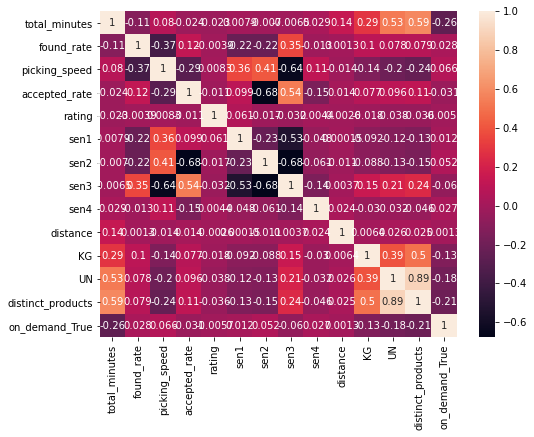

In [376]:
#correlation matrix
corr_df = data.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

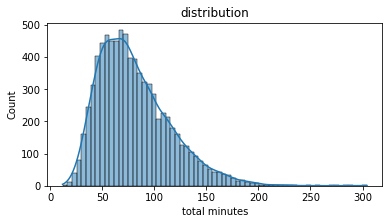

In [402]:
# Distribution of response variable
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=data, x='total_minutes', kde=True,ax=ax)
ax.set_title("distribution")
ax.set_xlabel('total minutes');

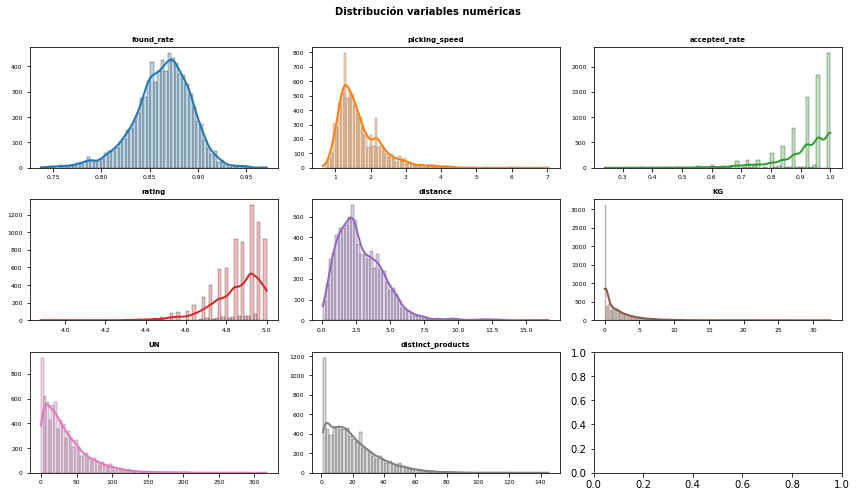

In [404]:
# Distributions of variables
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat
columnas_numeric = data.select_dtypes(include=['float64']).columns
columnas_numeric = columnas_numeric.drop('total_minutes')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = data,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

### Step 5) Model: Predicting total minutes

#### Model: Linear Regression

In [377]:
### División de la data en train y test 

X = data.drop(['total_minutes'],axis=1)
y = data['total_minutes']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                       shuffle      = True
                                    )

In [381]:
model = LinearRegression()
model.fit(X_train,y_train)
score = model.score(X_test,y_test)
print(score)

0.45734209015835015


In [392]:
importance = model.coef_
importance

array([[-8.81744869e+01,  1.16081271e+01, -2.23456261e+01,
        -2.66887377e+00, -8.64488944e-01, -4.61425068e+00,
        -8.10078446e-01,  6.28881807e+00,  2.46658994e+00,
         1.23185307e-01,  4.08278187e-02,  1.19564011e+00,
        -1.03517771e+01]])

In [398]:
importance[0]

array([-8.81744869e+01,  1.16081271e+01, -2.23456261e+01, -2.66887377e+00,
       -8.64488944e-01, -4.61425068e+00, -8.10078446e-01,  6.28881807e+00,
        2.46658994e+00,  1.23185307e-01,  4.08278187e-02,  1.19564011e+00,
       -1.03517771e+01])

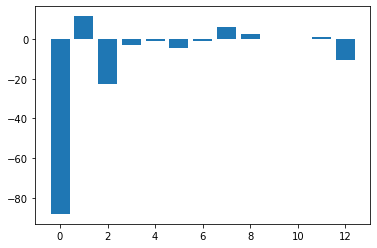

In [400]:
plt.bar([x for x in range(len(importance[0]))], importance[0])
plt.show()

#### Model: Neural Network 

In [406]:
# Identification of numeric columns (categorical columns already done)
numeric_cols = X_train.select_dtypes(include=['float64']).columns.to_list()


#Transformations for numeric variables

numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# The preprocessing steps and the model are combined in the same pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [407]:
# Search space of each hyperparameter
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Cross Validation Search
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Grid results
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
22,0.001,20,1000.0,-633.157684,45.677692,-612.126291,8.951073
36,0.001,"(10, 10)",1000.0,-635.339325,42.107196,-603.588606,10.488596
40,0.01,"(10, 10)",1000.0,-635.960949,43.680080,-605.626006,10.449677
43,0.01,"(10, 10)",215.443469,-638.110886,44.569644,-593.826535,8.838996
29,0.01,20,1000.0,-639.101158,34.346790,-624.707596,27.706864
23,0.01,20,215.443469,-640.917729,40.470426,-612.415773,19.554562
5,0.001,"(10, 10)",215.443469,-642.283561,39.606981,-599.735973,8.332728
27,0.001,20,215.443469,-642.512380,51.828342,-612.143580,15.652776
12,0.001,10,1000.0,-642.752614,40.356282,-627.677754,22.820211
32,0.01,10,0.004642,-644.357350,45.499022,-613.994189,13.283058


In [410]:
# Error test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error (rmse): ', rmse)

Error (rmse):  25.072032143252553


In [411]:
modelo_final['modelo'].get_params()

{'activation': 'relu',
 'alpha': 1000.0,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 20,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 1000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

#### The result for the best model is shown above, with an error of 25.072032143252553